# Problem Statement:-

A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

In [1]:
import math
import os
import re

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import Binarizer, LabelEncoder, StandardScaler
from statsmodels.tools import add_constant as ac

sc = StandardScaler()
le = LabelEncoder()

from sklearn.ensemble import (BaggingRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (KFold, RandomizedSearchCV,
                                     StratifiedKFold, train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

rfr = RandomForestRegressor()

import warnings

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
from sklearn.svm import SVR
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

In [3]:
for i in train.columns:
    if i not in test.columns:
        target_var = i
        print(target_var)

'Purchase'

In [4]:
# This function would return the last created submission file with the name 
# provided(x), so that the next submission file would be named with the next 
# number automatically. 
# Like Sub1, Sub2.  

def ret_latest_file(x):
    ans = os.listdir()
    finlist = []
    re_pat = re.compile("([a-zA-Z]+)([0-9]+)")
    for i in ans:
        try:            
            if i[-3:] == 'csv':
                res = re_pat.match(i).groups() #type: ignore
                if res[0] == x:
                    finlist.append(int(res[1]))            
        except:
            pass
    if len(finlist) > 0:
        return x, max(finlist)
    else:
        return x, 0

In [5]:
# Preparing Data for submission

def sub(n, pred):
    name, num = ret_latest_file(n)
    sol = pd.read_csv('./Data/sample_submission.csv')
    sol.loc[:, target_var] = pred #type: ignore
    sol.to_csv(f'./Submissions/{name}_{num+1}.csv', index=False)

In [7]:
# Splitting combined into x_train, x_test, y_train, y_test

def split_data(df, y = target_var):

    x_train = df[df[y].notnull()]
    x_train.drop(y, inplace=True, axis=1)

    x_test = df[df[y].isnull()]
    x_test.drop(y, inplace=True, axis=1)
    y_train = df[df[y].notnull()][y]

    y_test = df[df[y].isna()][y]

    return x_train, x_test, y_train, y_test

In [6]:
# Feature Importance

def feat_imp(df, model):
    x_train, x_test, y_train, y_test = split_data(df)
    features = model.feature_importances_
    sorted_indices = np.argsort(features)[::-1]
    plt.title('Feature Importance')
    plt.bar(range(x_train.shape[1]), features[sorted_indices], align='center')
    plt.xticks(range(x_train.shape[1]), x_train.columns[sorted_indices], rotation=90)
    plt.tight_layout()
    plt.show()

    return list(x_train.columns[sorted_indices])

In [8]:
# Base Model Submission

# sub("Base", train.Purchase.mean())

# RMSE: 4982

In [9]:
# Lets combined the datesets

combined = pd.concat([train, test], sort=False, ignore_index=True)

In [10]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783667 entries, 0 to 783666
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     783667 non-null  int64  
 1   Product_ID                  783667 non-null  object 
 2   Gender                      783667 non-null  object 
 3   Age                         783667 non-null  object 
 4   Occupation                  783667 non-null  int64  
 5   City_Category               783667 non-null  object 
 6   Stay_In_Current_City_Years  783667 non-null  object 
 7   Marital_Status              783667 non-null  int64  
 8   Product_Category_1          783667 non-null  int64  
 9   Product_Category_2          537685 non-null  float64
 10  Product_Category_3          237858 non-null  float64
 11  Purchase                    550068 non-null  float64
dtypes: float64(3), int64(4), object(5)
memory usage: 71.7+ MB


In [11]:
combined.Occupation.unique() 
# Making it categorical would create 16 different categories. One Hot Encoding Not Recommended.

array([10, 16, 15,  7, 20,  9,  1, 12, 17,  0,  3,  4, 11,  8, 19,  2, 18,
        5, 14, 13,  6], dtype=int64)

In [12]:
to_be_cat = ['Occupation','Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']
obj_data = list(combined.select_dtypes(['object']))
for i in obj_data:
    to_be_cat.append(i)
combined[to_be_cat] = combined[to_be_cat].astype('category')
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783667 entries, 0 to 783666
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   User_ID                     783667 non-null  int64   
 1   Product_ID                  783667 non-null  category
 2   Gender                      783667 non-null  category
 3   Age                         783667 non-null  category
 4   Occupation                  783667 non-null  category
 5   City_Category               783667 non-null  category
 6   Stay_In_Current_City_Years  783667 non-null  category
 7   Marital_Status              783667 non-null  category
 8   Product_Category_1          783667 non-null  category
 9   Product_Category_2          537685 non-null  category
 10  Product_Category_3          237858 non-null  category
 11  Purchase                    550068 non-null  float64 
dtypes: category(10), float64(1), int64(1)
memory usage: 20.3 M

## ***EDA Process***

### **1. Univariate Analysis - Single Variable Analysis.**


Two types of column : Numeric and Categorical

For Numeric : Histogram

For Categorical : Frequency Table / Countplot.



In [13]:
not_to_plot = ['User_ID', 'Product_ID']
color = ['blue', 'red','green']

In [14]:
def univariate(df = combined, rows = 5, cols = 2):
    k = 0
    fig=plt.figure(figsize=(20,20))
    for i in df.columns:
        if i not in not_to_plot:
            if i in df.select_dtypes(['category', 'object']).columns:
                ax=fig.add_subplot(rows,cols,k+1)
                sns.countplot(x= i, data = df, ax=ax)
                plt.xticks(rotation = 45)
                k += 1
            if i in df.select_dtypes(['int', 'float']).columns:
                ax=fig.add_subplot(rows,cols,k+1)
                sns.distplot(x = df[i], ax=ax, color=np.random.choice(color))
                ax.set(xlabel=i)
                k += 1
    fig.tight_layout() 
    plt.show()

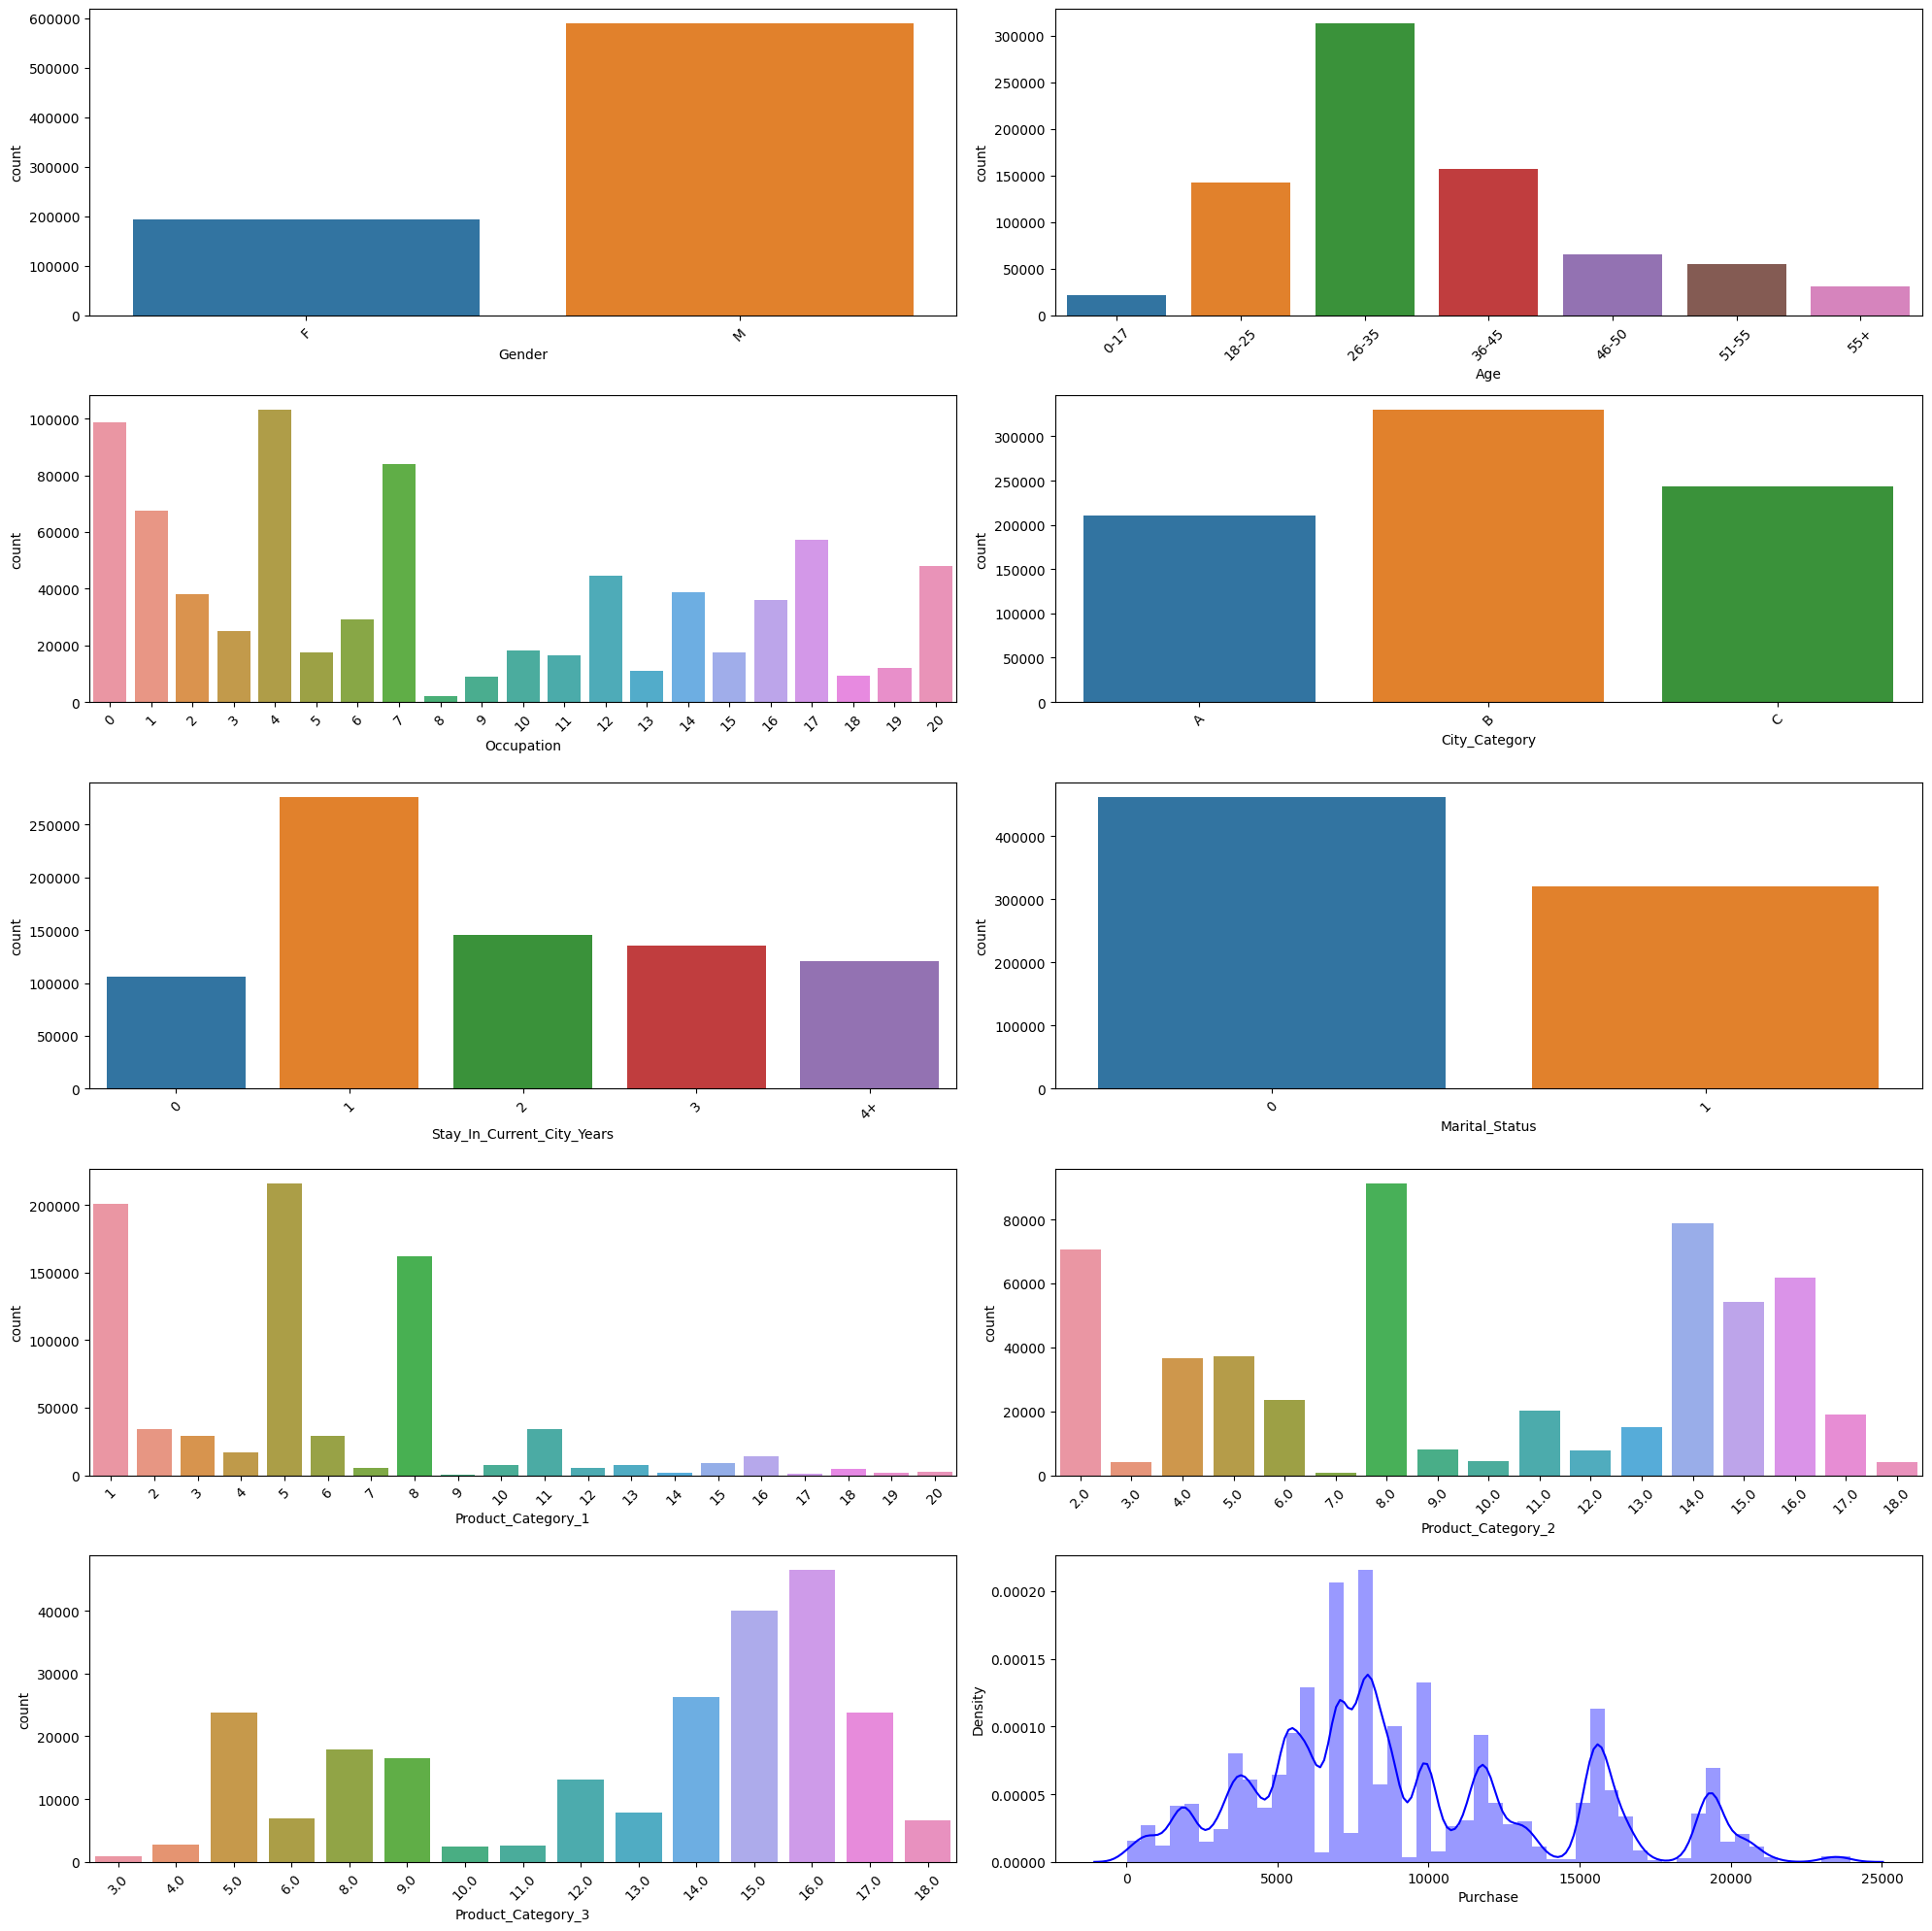

In [15]:
univariate()

### **2. Bivariate Analysis - Two Variable Analysis.**


Numeric vs Numeric - Scatter Plot.

Numeric vs Categorical - Box Plot or Bar Plot.



In [16]:
def bivariate(df = combined, y = target_var, cols = 3, rows = 3):
    temp = not_to_plot[:]
    temp.append(y)
    k = 0
    fig=plt.figure(figsize=(25,20))

    for i in df.columns:
        if i not in temp:
            if y in df.select_dtypes(['float', 'int']):
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp): 
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.boxplot(x = i, y = y, data = df)

                if i in df.select_dtypes(['float', 'int']):                
                    if (i not in temp):      
                        ax=fig.add_subplot(rows,cols,k+1)       
                        sns.scatterplot(x = y, y = i, data = df)                  
                k += 1
            elif y in df.select_dtypes(['category', 'object']):
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.countplot(x = i, hue = y, data = df)
                        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

                if i in df.select_dtypes(['float', 'int']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.boxplot(x = y, y = i, data = df)
                k += 1
    fig.tight_layout() 
    plt.show()

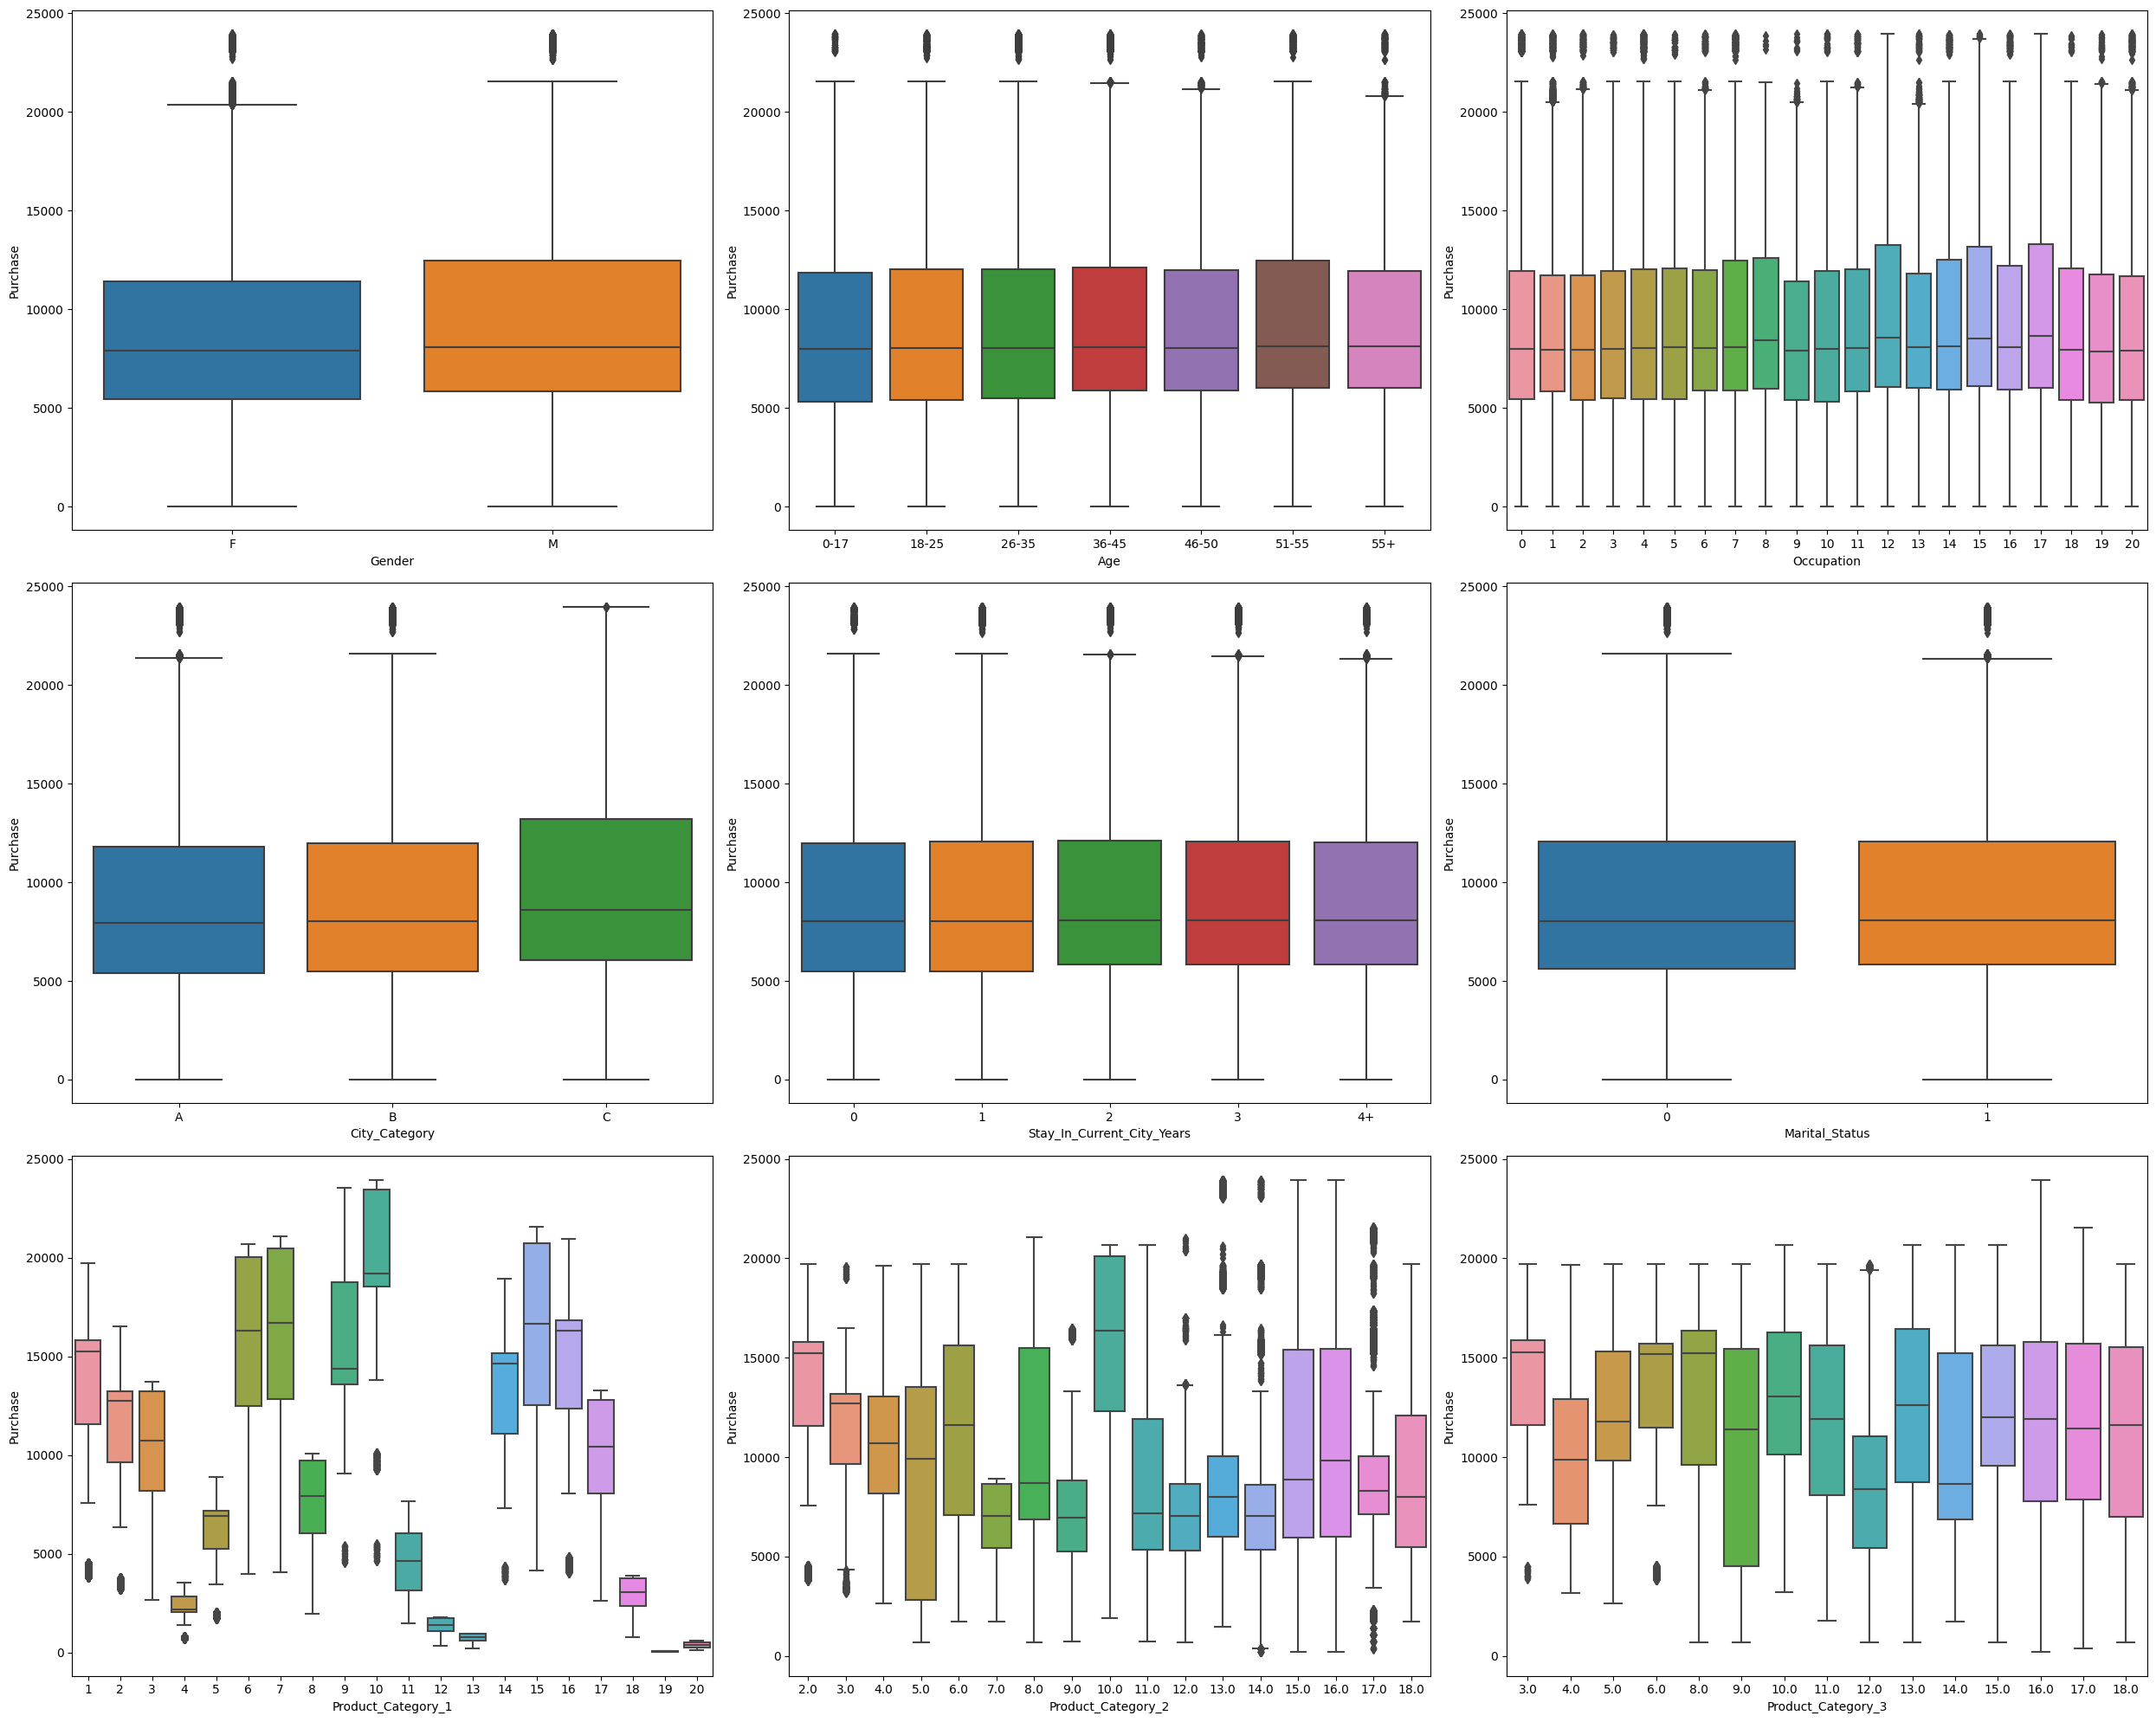

In [17]:
bivariate()

In [18]:
combined.groupby("Age")['Purchase'].describe()

,count,mean,std,min,25%,50%,75%,max
Age,,,,,,,,
0-17,15102.0,8933.464640,5111.114046,12.0,5328.0,7986.0,11874.0,23955.0
18-25,99660.0,9169.663606,5034.321997,12.0,5415.0,8027.0,12028.0,23958.0
26-35,219587.0,9252.690633,5010.527303,12.0,5475.0,8030.0,12047.0,23961.0
36-45,110013.0,9331.350695,5022.923879,12.0,5876.0,8061.0,12107.0,23960.0
46-50,45701.0,9208.625697,4967.216367,12.0,5888.0,8036.0,11997.0,23960.0
51-55,38501.0,9534.808031,5087.368080,12.0,6017.0,8130.0,12462.0,23960.0
55+,21504.0,9336.280459,5011.493996,12.0,6018.0,8105.5,11932.0,23960.0


1. Black Friday has products for all age types

2. The Avg and SD is nearly same for all age groups. Hence the products are similar as everyone is spending almost same amount.

Extract a New feature called Purchase Price Per Person.

In [19]:
# Extracting Product_ID Ending from Product_ID 

def extract(x):
    return int(x[1:])

combined['ID_Num'] = combined.Product_ID.apply(extract)
combined.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,ID_Num
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370.0,69042
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200.0,248942
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422.0,87842
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057.0,85442
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969.0,285442


### **3. Missing Values.**

In [20]:
combined.isnull().sum()[combined.isnull().sum()>0]

Product_Category_2    245982
Product_Category_3    545809
Purchase              233599
dtype: int64

#### Product Category 2

In [21]:
def rand_val_ret(x):
    lst = list(combined[combined.Product_Category_1 == x].Product_Category_2.value_counts()[combined[combined.Product_Category_1 == x].Product_Category_2.value_counts()>0].index)
    if len(lst) > 0:
        return np.random.choice(lst)
    else:
        return combined.Product_Category_2.value_counts().index[0]
# rand_val_ret(16)

In [22]:
# # Looks like Product_Category_2 is dependent on Product_Category_1.
# # Imputing the Values.

for i in combined.Product_Category_1.unique():
    for j in combined.ID_Num.unique():
        if len(combined.loc[
            (combined.Product_Category_1 == i) & 
            (combined.ID_Num == j) & 
            (combined.Product_Category_2.isnull()), 'Product_Category_2']) > 0: # type: ignore
            combined.loc[
                (combined.Product_Category_1 == i) & 
                (combined.ID_Num == j) & 
                (combined.Product_Category_2.isnull()), 'Product_Category_2'] = rand_val_ret(i)   # type: ignore

In [23]:
combined.isnull().sum()[combined.isnull().sum()>0]

Product_Category_3    545809
Purchase              233599
dtype: int64

#### Product Category 3

Depends on "Product Category 1" and "Product Category 2"

In [24]:
for i in combined.Product_Category_1.unique():
    for j in combined.Product_Category_2.unique():
        if len(combined[
            (combined.Product_Category_1 == i) & 
            (combined.Product_Category_2 == j) & 
            (combined.Product_Category_3.isnull())]) > 0:
            if combined[
                (combined.Product_Category_1 == i) & 
                (combined.Product_Category_2 == j)].Product_Category_3.value_counts().sum() == 0:
                combined.loc[
                    (combined.Product_Category_1 == i) & 
                    (combined.Product_Category_2 == j) & 
                    (combined.Product_Category_3.isnull()), 'Product_Category_3'] = combined.Product_Category_3.value_counts().index[0]  # type: ignore  
        else:
            combined.loc[(combined.Product_Category_1 == i) & (combined.Product_Category_2 == j) & (combined.Product_Category_3.isnull()), 'Product_Category_3'] = combined[(combined.Product_Category_1 == i) & (combined.Product_Category_2 == j)].Product_Category_3.value_counts().index[0]

In [25]:
combined.isnull().sum()[combined.isnull().sum()>0]

Purchase    233599
dtype: int64

In [26]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783667 entries, 0 to 783666
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   User_ID                     783667 non-null  int64   
 1   Product_ID                  783667 non-null  category
 2   Gender                      783667 non-null  category
 3   Age                         783667 non-null  category
 4   Occupation                  783667 non-null  category
 5   City_Category               783667 non-null  category
 6   Stay_In_Current_City_Years  783667 non-null  category
 7   Marital_Status              783667 non-null  category
 8   Product_Category_1          783667 non-null  category
 9   Product_Category_2          783667 non-null  category
 10  Product_Category_3          783667 non-null  category
 11  Purchase                    550068 non-null  float64 
 12  ID_Num                      783667 non-null  category
dtyp

In [27]:
combined.drop(['User_ID', 'Product_ID', 'ID_Num'], axis = 1, inplace=True)

In [28]:
combined_en = combined[:]
lb = ['Age', 'Stay_In_Current_City_Years', 'Occupation', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']
combined_en[lb] = combined_en[lb].apply(LabelEncoder().fit_transform)

gd = ['Gender', 'City_Category', 'Marital_Status']
combined_en = pd.get_dummies(combined_en, columns = gd, drop_first=True)

combined_en.head()

,Age,Occupation,Stay_In_Current_City_Years,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Gender_M,City_Category_B,City_Category_C,Marital_Status_1
0,0,10,2,2,2,2,8370.0,0,0,0,0
1,0,10,2,0,4,10,15200.0,0,0,0,0
2,0,10,2,11,15,12,1422.0,0,0,0,0
3,0,10,2,11,12,13,1057.0,0,0,0,0
4,6,16,4,7,8,12,7969.0,1,0,1,0


### **4. Model Building.**

In [29]:
# General Random Search Model that could be used by all Classification Models. 

def rand_search(model, params, df, subm = 'yes'):
    x_train, x_test, y_train, y_test = split_data(df)

    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)

    grid_mod = RandomizedSearchCV(model, param_distributions=params, scoring = ['explained_variance'], cv = 10, n_jobs=8, refit='explained_variance')
    grid_mod.fit(x_train, y_train)

    if subm == 'yes':
        y_pred = grid_mod.predict(x_test)
        sub(str(model)[:4], y_pred)

    return grid_mod.best_estimator_, grid_mod.best_score_

#### Linear Regression

In [30]:
combined_lb = combined.loc[combined[target_var].notnull(),:].apply(LabelEncoder().fit_transform)
x = combined_lb.loc[:, combined_lb.columns != target_var]
y = combined_lb.loc[:, target_var]


x= ac(x)

est=sm.OLS(y, x).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Purchase   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     9316.
Date:                Fri, 27 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:07:07   Log-Likelihood:            -5.3173e+06
No. Observations:              550068   AIC:                         1.063e+07
Df Residuals:                  550058   BIC:                         1.063e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       7537.8016     24.836    303.509      0.000    7489.125    7586.478
Gender                       408.5498     12.040     33.932      0.000     384.952     432.148
Age                           95.1621      4.055     23.466      0.000      87.214     103.110
Occupation                     5.1797      0.799      6.483      0.000       3.614       6.746
City_Category                284.5000      6.831     41.649      0.000     271.112     297.888
Stay_In_Current_City_Years     7.1452      3.997      1.788      0.074      -0.688      14.978
Marital_Status               -44.0310     11.021     -3.995      0.000     -65.632     -22.430
Product_Category_1          -315.8051      1.535   -205.763      0.000    -318.813    -312.797
Product_Category_2          -115.1242      1.562    -73.690      0.000    -118.186    -112.062
Product_Category_3           120.1153      2.239     53.642      0.000     115.727     124.504
==============================================================================
Omnibus:                    47275.244   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61129.389
Skew:                           0.763   Prob(JB):                         0.00
Kurtosis:                       3.583   Cond. No.                         88.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
params_lg = {
    'fit_intercept': [True, False]
}

In [32]:
mod_lg, exp_var_lg = rand_search(model = LinearRegression(), params = params_lg, df = combined_en)
exp_var_lg

0.13119335636795945

#### Light GBM

In [ ]:
params_lgbm = {
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [30, 40, 50, 60, 70],    
    'n_jobs':[-1]
}

In [ ]:
mod_lgbm, exp_var_lgbm = rand_search(model = LGBMRegressor(), params = params_lgbm, df = combined_en)
exp_var_lgbm

#### Random Forest Regressor

In [ ]:
params_rf = {
    'n_estimators' : [50, 70, 100, 120, 140],
    'criterion':['squared_error','absolute_error','poisson'],
    'bootstrap':[True, False],
    'n_jobs':[-1],
    'oob_score': [True],
    'max_depth': [10, 15, 20, 25, 40],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
mod_rf, exp_var_rf = rand_search(model = RandomForestRegressor(), params = params_rf, df = combined_en, subm = 'yes')
exp_var_rf

#### SVR

In [33]:
params_svr = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale','auto'],
    'C': [0.1, 1, 10, 100],
}

In [34]:
mod_svr, exp_var_svr = rand_search(model = SVR(), params = params_svr, df = combined_en)
exp_var_svr